In [1]:
import pandas as pd
pd.set_option("display.max_rows", 200)
import os
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import datetime

In [2]:
filedir = "/public/hanl/jupyter_dir/ir_recommend_v2/00.data/raw/"
infile = filedir + '/ir_icu_allfeature.csv'

df_fea = pd.read_csv(infile)
df_fea["charttime"] = pd.to_datetime(df_fea["charttime"], format='%d/%m/%Y %H:%M:%S')
df_fea = df_fea.drop_duplicates()
print(df_fea.shape)
df_fea.head(1)

(2328804, 92)


,subject_id,hadm_id,stay_id,charttime,heart_rate,sbp,dbp,mbp,sbp_ni,dbp_ni,...,alp,ast,amylase,bilirubin_total,bilirubin_direct,bilirubin_indirect,ck_cpk,ggt,ld_ldh,crp
0,10002013,23581541.0,39060235,2160-05-18 10:26:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 异常值探索

['neutrophils_abs' 'ck_cpk' 'fibrinogen' 'pao2fio2ratio' 'ld_ldh'
 'urineoutput' 'ast' 'alt' 'glucose' 'alp' 'amylase' 'd_dimer' 'ggt'
 'platelet' 'lymphocytes_abs' 'sodium' 'monocytes_abs']


/home/hanl/miniconda3/envs/AUMCdb/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


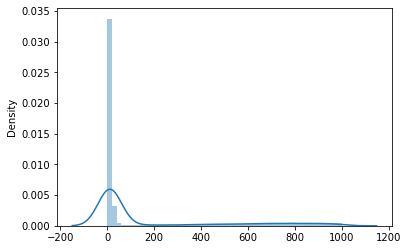

In [3]:
tmp_df = df_fea.loc[:,['heart_rate', 'sbp',
       'dbp', 'mbp', 'sbp_ni', 'dbp_ni', 'mbp_ni', 'resp_rate', 'temperature',
       'spo2', 'glucose', 'gcs_motor', 'gcs_verbal', 'gcs_eyes', 'gcs',
       'gcs_unable', 'urineoutput', 'so2', 'po2', 'pco2', 'fio2_chartevents',
       'fio2', 'aado2', 'aado2_calc', 'pao2fio2ratio', 'ph', 'baseexcess',
       'bicarbonate', 'chloride', 'ck_mb', 'hematocrit', 'hemoglobin',
       'potassium', 'sodium', 'wbc', 'free_calcium', 'calcium', 'totalco2',
       'carboxyhemoglobin', 'methemoglobin', 'lactate', 'basophils_abs',
       'eosinophils_abs', 'lymphocytes_abs', 'monocytes_abs',
       'neutrophils_abs', 'basophils', 'eosinophils', 'lymphocytes',
       'monocytes', 'neutrophils', 'atypical_lymphocytes', 'bands',
       'immature_granulocytes', 'metamyelocytes', 'nrbc', 'troponin_i',
       'troponin_t', 'albumin', 'globulin', 'total_protein', 'aniongap', 'bun',
       'creatinine', 'd_dimer', 'fibrinogen', 'thrombin', 'inr', 'pt', 'ptt',
       'mch', 'mchc', 'mcv', 'platelet', 'rbc', 'rdw', 'rdwsd', 'alt', 'alp',
       'ast', 'amylase', 'bilirubin_total', 'bilirubin_direct',
       'bilirubin_indirect', 'ck_cpk', 'ggt', 'ld_ldh', 'crp']]

print(tmp_df[tmp_df>1000].stack().reset_index().level_1.unique())
outlier_fea = tmp_df[tmp_df>1000].stack().reset_index().level_1.unique()

fea = "neutrophils_abs"
lst = tmp_df[~tmp_df[fea].isnull()][fea]
sns.distplot([i for i in lst if (i<1000)])

for i in outlier_fea:
    df_fea.loc[df_fea[i]>=1000,i] = np.nan
df_fea.loc[df_fea["glucose"]<=10,"glucose"] = np.nan

In [4]:
df_fea.to_csv("ir_icu_allfeature_Foutlier.csv",index=False)

# 葡糖单表形成

In [5]:
df_glu = df_fea.loc[:,['stay_id', 'charttime', 'glucose']]
df_glu = df_glu.dropna(how='all', subset=['glucose'])
df_glu = df_glu.drop_duplicates()
print(df_glu.shape)
df_glu.head(2)

(519255, 3)


,stay_id,charttime,glucose
0,39060235,2160-05-18 10:26:00,216.0
1,39060235,2160-05-18 11:23:00,177.0


In [6]:
# 检查有多少葡糖记录相隔不到两分钟
tmp_df = pd.DataFrame()
for i,j in df_glu.groupby(by=["stay_id"]):
    j = j.sort_values(by=["stay_id", "charttime"])
    j["next_charttime"] = j["charttime"].shift(-1)
    j["next_glucose"] = j["glucose"].shift(-1)
    tmp_df = pd.concat([tmp_df, j], axis=0)

tmp_df["interval"] = (tmp_df["next_charttime"] - tmp_df["charttime"]).map(lambda x:x/np.timedelta64(1, 'm')).tolist()
tmp_df.head(3)

,stay_id,charttime,glucose,next_charttime,next_glucose,interval
723602,30000213,2162-06-21 06:00:00,125.0,2162-06-21 07:00:00,108.0,60.0
723605,30000213,2162-06-21 07:00:00,108.0,2162-06-21 07:45:00,97.0,45.0
723607,30000213,2162-06-21 07:45:00,97.0,2162-06-21 08:15:00,156.0,30.0


In [7]:
print(tmp_df[tmp_df["interval"]<=10].shape)
del_ = tmp_df[tmp_df["interval"]<=10].loc[:,["stay_id", "charttime", "glucose"]]

(18011, 6)


In [8]:
df_glu_filt = pd.concat([df_glu, del_, del_]).drop_duplicates(keep=False, subset=["stay_id", "charttime", "glucose"]) 
df_glu_filt.shape

(501244, 3)

In [9]:
df_glu_filt.to_csv("ir_icu_glucose.csv", index = False)